## <center>Тест<a class="anchor" id="course_project"></a><center>

In [1]:
# 1. Основные библиотеки
import numpy as np
import pandas as pd
import pickle   # сохранение модели

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 2. Разделение датасета
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, learning_curve

# 3. Модели
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

import xgboost as xgb
import lightgbm as lgbm
import catboost as catb

# 4. Метрики качества
from sklearn.metrics import mean_squared_error as mse, r2_score as r2
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

# 5. Для визуализации внешних картинок в ноутбуке
from IPython.display import Image
from scipy.interpolate import make_interp_spline

In [2]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.25, 0.35, 20):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
      
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.axhline(0.5, color="red")
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=0.5)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [3]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [4]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (14, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()

    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [5]:
def filling_empty_cells_train(prizn):
    
    global X
    global X_nan
    
    # Масштабируем RandomForestRegressor, GradientBoostingRegressor
    #scaler = StandardScaler()
    X = scaler.fit_transform(X)
    X_nan = scaler.fit_transform(X_nan)
    
    # Обучаем модель и предсказываем пропущенные значения. Записываем их на место пропусков
    gbr = GradientBoostingRegressor(random_state=21)
    gbr.fit(X, y)
    y_pred = gbr.predict(X_nan)
    df_train.loc[df_train[prizn].isna(), prizn] = y_pred

In [6]:
def filling_empty_cells_test(prizn):
        
    global X
    global X_nan
    
    # Масштабируем
    
    X = scaler.fit_transform(X)
    X_nan = scaler.fit_transform(X_nan)
    
    # Обучаем модель и предсказываем пропущенные значения. Записываем их на место пропусков
    gbr = GradientBoostingRegressor(random_state=21)
    gbr.fit(X, y)
    y_pred = gbr.predict(X_nan)
    df_test.loc[df_test[prizn].isna(), prizn] = y_pred

In [7]:
def GiniIndex(p):
    #Коэффициент Джини
    cum = np.cumsum(sorted(np.append(p, 0)))
    sum = cum[-1]
    x1 = np.array(range(len(cum))) / len(p)
    y1 = cum / sum
    B = np.trapz(y1, x=x1)
    A = 0.5 - B
    G = A / (A + B)
    #Рисование
    plt.rcParams['font.sans-serif'] = ['SimHei']
    fig, ax = plt.subplots()
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.spines['bottom'].set_position(('data', -0))
    ax.spines['left'].set_position(('data', 0))
    plt.xticks([0, 1.0])
    plt.yticks([1.0])
    plt.axis('scaled')
    x_smooth = np.linspace(x1.min(), x1.max(), 100)
    y_smooth = make_interp_spline(x1, y1)(x_smooth)
    ax.plot(x_smooth, y_smooth, color='black')
    ax.plot(x1, x1, color='black')
    ax.plot([0, 1, 1, 1], [0, 0, 0, 1], color='black')
    ax.fill_between(x1, y1)
    ax.fill_between(x1, x1, y1, where=y1 <= x1)
    ax.set_xlabel('вероятность')
    ax.set_ylabel('количество')
    plt.show()
    return G

**Пути к директориям и файлам**

In [8]:
TRAIN_DATASET_PATH = 'C:/Users/vanex/Downloads/Задание ML для кандидата/data.csv'
TEST_DATASET_PATH = 'C:/Users/vanex/Downloads/Задание ML для кандидата/verify.csv'

**Загрузка тренировочных данных**

In [9]:
df_train = pd.read_csv(TRAIN_DATASET_PATH, delimiter =';')
df_train.head()

,ID,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_116,feature_117,feature_118,feature_119,feature_120,feature_121,feature_122,feature_123,feature_124,target
0,1,1,0,0,1381,63,0,0,1,0,...,0,0,0,0.0,7000,4000,7526.3157,12000,0.583333,0
1,2,0,0,0,1809,33,1,0,1,0,...,0,0,0,0.0,10000,1000,8393.4426,30000,0.333333,0
2,3,0,0,0,1804,29,0,1,0,0,...,0,0,0,0.0,3000,1000,3425.9259,15000,0.200000,0
3,4,0,0,0,1560,28,1,1,0,0,...,0,0,0,0.0,2000,1000,1946.6666,3000,0.666667,0
4,5,0,0,0,258,33,1,0,0,0,...,0,0,0,0.0,2000,2000,4444.4444,8000,0.250000,0


**Обзор количественных признаков**

In [10]:
df_train.shape

(255820, 126)

In [11]:
df_train.describe(include='all')

,ID,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_116,feature_117,feature_118,feature_119,feature_120,feature_121,feature_122,feature_123,feature_124,target
count,255820.000000,255820.000000,255820.000000,255820.000000,255820.000000,255820.000000,255820.000000,255820.000000,255820.000000,255820.000000,...,255820.000000,255820.000000,255820.000000,255820.000000,255820.000000,255820.000000,255820.000000,255820.000000,255820.000000,255820.000000
mean,127910.500000,0.356731,0.147756,0.002564,819.453049,41.053213,0.412751,0.355516,0.372434,0.063498,...,0.015581,0.026964,0.035990,0.005929,7201.150125,2866.290818,5904.254582,12100.793241,0.659698,0.197444
std,73849.017269,0.479035,0.354859,0.050574,772.966593,13.754019,0.492330,0.478670,0.483454,0.243857,...,0.123849,0.161979,0.256262,0.057655,8139.745183,3241.112692,4832.221046,9928.531737,0.343397,0.398071
min,1.000000,0.000000,0.000000,0.000000,-18.000000,18.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1000.000000,1000.000000,1000.000000,1000.000000,0.016667,0.000000
25%,63955.750000,0.000000,0.000000,0.000000,163.000000,30.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,2000.000000,1000.000000,2559.024050,5000.000000,0.333333,0.000000
50%,127910.500000,0.000000,0.000000,0.000000,562.000000,38.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,4000.000000,2000.000000,4277.777700,10000.000000,0.705882,0.000000
75%,191865.250000,1.000000,0.000000,0.000000,1329.000000,52.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,10000.000000,3000.000000,7638.338725,16000.000000,1.000000,0.000000
max,255820.000000,1.000000,1.000000,1.000000,3451.000000,82.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,12.000000,1.000000,99000.000000,60000.000000,60000.000000,99000.000000,1.000000,1.000000


**Обзор целевой переменной**

In [12]:
df_train['target'].value_counts(normalize=True)

0    0.802556
1    0.197444
Name: target, dtype: float64

### Список всех колонок<a class="anchor" id="gaps"></a>

In [13]:
df_train.columns.values

array(['ID', 'feature_1', 'feature_2', 'feature_3', 'feature_4',
       'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9',
       'feature_10', 'feature_11', 'feature_12', 'feature_13',
       'feature_14', 'feature_15', 'feature_16', 'feature_17',
       'feature_18', 'feature_19', 'feature_20', 'feature_21',
       'feature_22', 'feature_23', 'feature_24', 'feature_25',
       'feature_26', 'feature_27', 'feature_28', 'feature_29',
       'feature_30', 'feature_31', 'feature_32', 'feature_33',
       'feature_34', 'feature_35', 'feature_36', 'feature_37',
       'feature_38', 'feature_39', 'feature_40', 'feature_41',
       'feature_42', 'feature_43', 'feature_44', 'feature_45',
       'feature_46', 'feature_47', 'feature_48', 'feature_49',
       'feature_50', 'feature_51', 'feature_52', 'feature_53',
       'feature_54', 'feature_55', 'feature_56', 'feature_57',
       'feature_58', 'feature_59', 'feature_60', 'feature_61',
       'feature_62', 'feature_63', 'feature_

### Обработка пропусков<a class="anchor" id="gaps"></a>

**Процентный список пропущенных данных**

In [14]:
for col in df_train.columns:
    pct_missing = np.mean(df_train[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

ID - 0.0%
feature_1 - 0.0%
feature_2 - 0.0%
feature_3 - 0.0%
feature_4 - 0.0%
feature_5 - 0.0%
feature_6 - 0.0%
feature_7 - 0.0%
feature_8 - 0.0%
feature_9 - 0.0%
feature_10 - 0.0%
feature_11 - 0.0%
feature_12 - 0.0%
feature_13 - 0.0%
feature_14 - 0.0%
feature_15 - 0.0%
feature_16 - 0.0%
feature_17 - 0.0%
feature_18 - 0.0%
feature_19 - 0.0%
feature_20 - 0.0%
feature_21 - 0.0%
feature_22 - 0.0%
feature_23 - 0.0%
feature_24 - 0.0%
feature_25 - 0.0%
feature_26 - 0.0%
feature_27 - 0.0%
feature_28 - 0.0%
feature_29 - 0.0%
feature_30 - 0.0%
feature_31 - 0.0%
feature_32 - 0.0%
feature_33 - 0.0%
feature_34 - 0.0%
feature_35 - 0.0%
feature_36 - 0.0%
feature_37 - 0.0%
feature_38 - 0.0%
feature_39 - 0.0%
feature_40 - 0.0%
feature_41 - 0.0%
feature_42 - 0.0%
feature_43 - 0.0%
feature_44 - 0.0%
feature_45 - 0.0%
feature_46 - 0.0%
feature_47 - 0.0%
feature_48 - 0.0%
feature_49 - 0.0%
feature_50 - 0.0%
feature_51 - 0.0%
feature_52 - 0.0%
feature_53 - 0.0%
feature_54 - 0.0%
feature_55 - 0.0%
feature_5

**Ниже будут напечатаны первые 10 столбцов Nan в порядке убывания**

In [15]:
df_train.isnull().sum().sort_values(ascending = False).head(10)

feature_106    41893
feature_105    37795
feature_104    37795
feature_103    37795
feature_102    37795
feature_38         0
feature_40         0
feature_39         0
target             0
feature_41         0
dtype: int64

### Неинформативные признаки
Составим список признаков, у которых более 99% строк содержат одно и то же значение

In [16]:
num_rows = len(df_train.index)
low_information_cols = [] #

for col in df_train.columns:
    cnts = df_train[col].value_counts(dropna=False)
    top_pct = (cnts/num_rows).iloc[0]
    
    if top_pct > 0.99:
        low_information_cols.append(col)
        df_train = df_train.drop(col, axis = 'columns') # здесь мы постепенно удаляем такие признаки
        print('{0}: {1:.5f}%'.format(col, top_pct*100))
        print(cnts)
        print()

feature_3: 99.74357%
0    255164
1       656
Name: feature_3, dtype: int64

feature_15: 99.43085%
0    254364
1      1456
Name: feature_15, dtype: int64

feature_20: 99.67125%
0    254979
1       841
Name: feature_20, dtype: int64

feature_22: 99.10992%
0    253543
1      2277
Name: feature_22, dtype: int64

feature_27: 99.98397%
0    255779
1        41
Name: feature_27, dtype: int64

feature_32: 99.84403%
0    255421
1       399
Name: feature_32, dtype: int64

feature_35: 99.07748%
0    253460
1      2360
Name: feature_35, dtype: int64

feature_37: 99.88234%
0    255519
1       301
Name: feature_37, dtype: int64

feature_41: 99.36831%
0    254204
1      1616
Name: feature_41, dtype: int64

feature_51: 99.99961%
0    255819
1         1
Name: feature_51, dtype: int64

feature_53: 99.89602%
0.00000       255554
351.00000          2
195.00000          2
1209.00000         2
474.86000          1
               ...  
429.78000          1
1154.59305         1
204.40480          1
2021.61380 

### Ищем дубликаты<a class="anchor" id="gaps"></a>

In [17]:
df_train.duplicated().sum()

0

**Построение гистограммы для обнаружения выбросов**

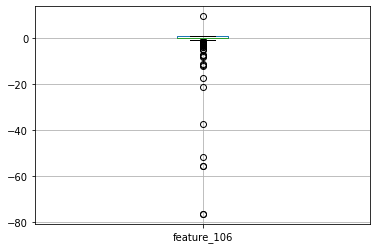

In [18]:
df_train.boxplot(column=['feature_106'])

#### Масштабируем

In [19]:
scaler = RobustScaler()

**Заполняем пропуски признаков 'feature_102' - 'feature_106'**

Разделяем на два датасета.

X содержит признаки для обучения.

y - все известные значения параметра.

X_nan - строки с пропущенным признаком параметра.

In [20]:
X = df_train.drop(['feature_102', 'feature_103', 'feature_104', 'feature_105', 'feature_106'], axis = 'columns')[~df_train['feature_102'].isna()]

y = df_train.loc[~df_train['feature_102'].isna(), 'feature_102'].astype(int)

X_nan = df_train.drop(['feature_102', 'feature_103', 'feature_104', 'feature_105', 'feature_106'], axis = 'columns')[df_train['feature_102'].isna()]

In [21]:
filling_empty_cells_train('feature_102')

In [22]:
X = df_train.drop(['feature_103', 'feature_104', 'feature_105', 'feature_106'], axis = 'columns')[~df_train['feature_103'].isna()]

y = df_train.loc[~df_train['feature_103'].isna(), 'feature_103'].astype(int)

X_nan = df_train.drop(['feature_103', 'feature_104', 'feature_105', 'feature_106'], axis = 'columns')[df_train['feature_103'].isna()]

In [23]:
filling_empty_cells_train('feature_103')

In [24]:
X = df_train.drop(['feature_104', 'feature_105', 'feature_106'], axis = 'columns')[~df_train['feature_104'].isna()]

y = df_train.loc[~df_train['feature_104'].isna(), 'feature_104'].astype(int)

X_nan = df_train.drop(['feature_104', 'feature_105', 'feature_106'], axis = 'columns')[df_train['feature_104'].isna()]

In [25]:
filling_empty_cells_train('feature_104')

In [26]:
X = df_train.drop(['feature_105', 'feature_106'], axis = 'columns')[~df_train['feature_105'].isna()]

y = df_train.loc[~df_train['feature_105'].isna(), 'feature_105'].astype(int)

X_nan = df_train.drop(['feature_105', 'feature_106'], axis = 'columns')[df_train['feature_105'].isna()]

In [27]:
filling_empty_cells_train('feature_105')

In [28]:
X = df_train.drop(['feature_106'], axis = 'columns')[~df_train['feature_106'].isna()]

y = df_train.loc[~df_train['feature_106'].isna(), 'feature_106'].astype(int)

X_nan = df_train.drop(['feature_106'], axis = 'columns')[df_train['feature_106'].isna()]

In [29]:
filling_empty_cells_train('feature_106')

### Построение модели классификации

**Выделение целевой переменной и групп признаков**

In [30]:
TARGET_NAME = 'target'

BASE_FEATURE_NAMES = df_train.columns.drop(TARGET_NAME).tolist()

**Разбиение на train и test**

In [31]:
X = df_train[BASE_FEATURE_NAMES]
y = df_train[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=21)
X_train.shape, X_test.shape, y_train.shape, y_test.shape 

((179074, 111), (76746, 111), (179074,), (76746,))

**Логистическая регрессия**

In [32]:
%%time

model_lr = LogisticRegression(random_state=21)
model_lr.fit(X_train, y_train)

y_train_pred = model_lr.predict(X_train)
y_test_pred = model_lr.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

C:\Users\vanex\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


TRAIN

              precision    recall  f1-score   support

           0       0.81      0.99      0.89    143606
           1       0.47      0.05      0.09     35468

    accuracy                           0.80    179074
   macro avg       0.64      0.52      0.49    179074
weighted avg       0.74      0.80      0.73    179074

TEST

              precision    recall  f1-score   support

           0       0.81      0.99      0.89     61704
           1       0.47      0.05      0.10     15042

    accuracy                           0.80     76746
   macro avg       0.64      0.52      0.49     76746
weighted avg       0.74      0.80      0.73     76746

CONFUSION MATRIX

col_0       0    1
target            
0       60796  908
1       14229  813
Wall time: 4.67 s


**Обучение модели на основе CatBoost**

In [33]:
%%time

model_catb = catb.CatBoostClassifier(silent=True, random_state=21)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.89      0.99      0.93    143606
           1       0.89      0.48      0.63     35468

    accuracy                           0.89    179074
   macro avg       0.89      0.73      0.78    179074
weighted avg       0.89      0.89      0.87    179074

TEST

              precision    recall  f1-score   support

           0       0.87      0.97      0.92     61704
           1       0.79      0.42      0.55     15042

    accuracy                           0.87     76746
   macro avg       0.83      0.70      0.74     76746
weighted avg       0.86      0.87      0.85     76746

CONFUSION MATRIX

col_0       0     1
target             
0       60006  1698
1        8659  6383
Wall time: 43.5 s


#### Оцениваем важность признаков

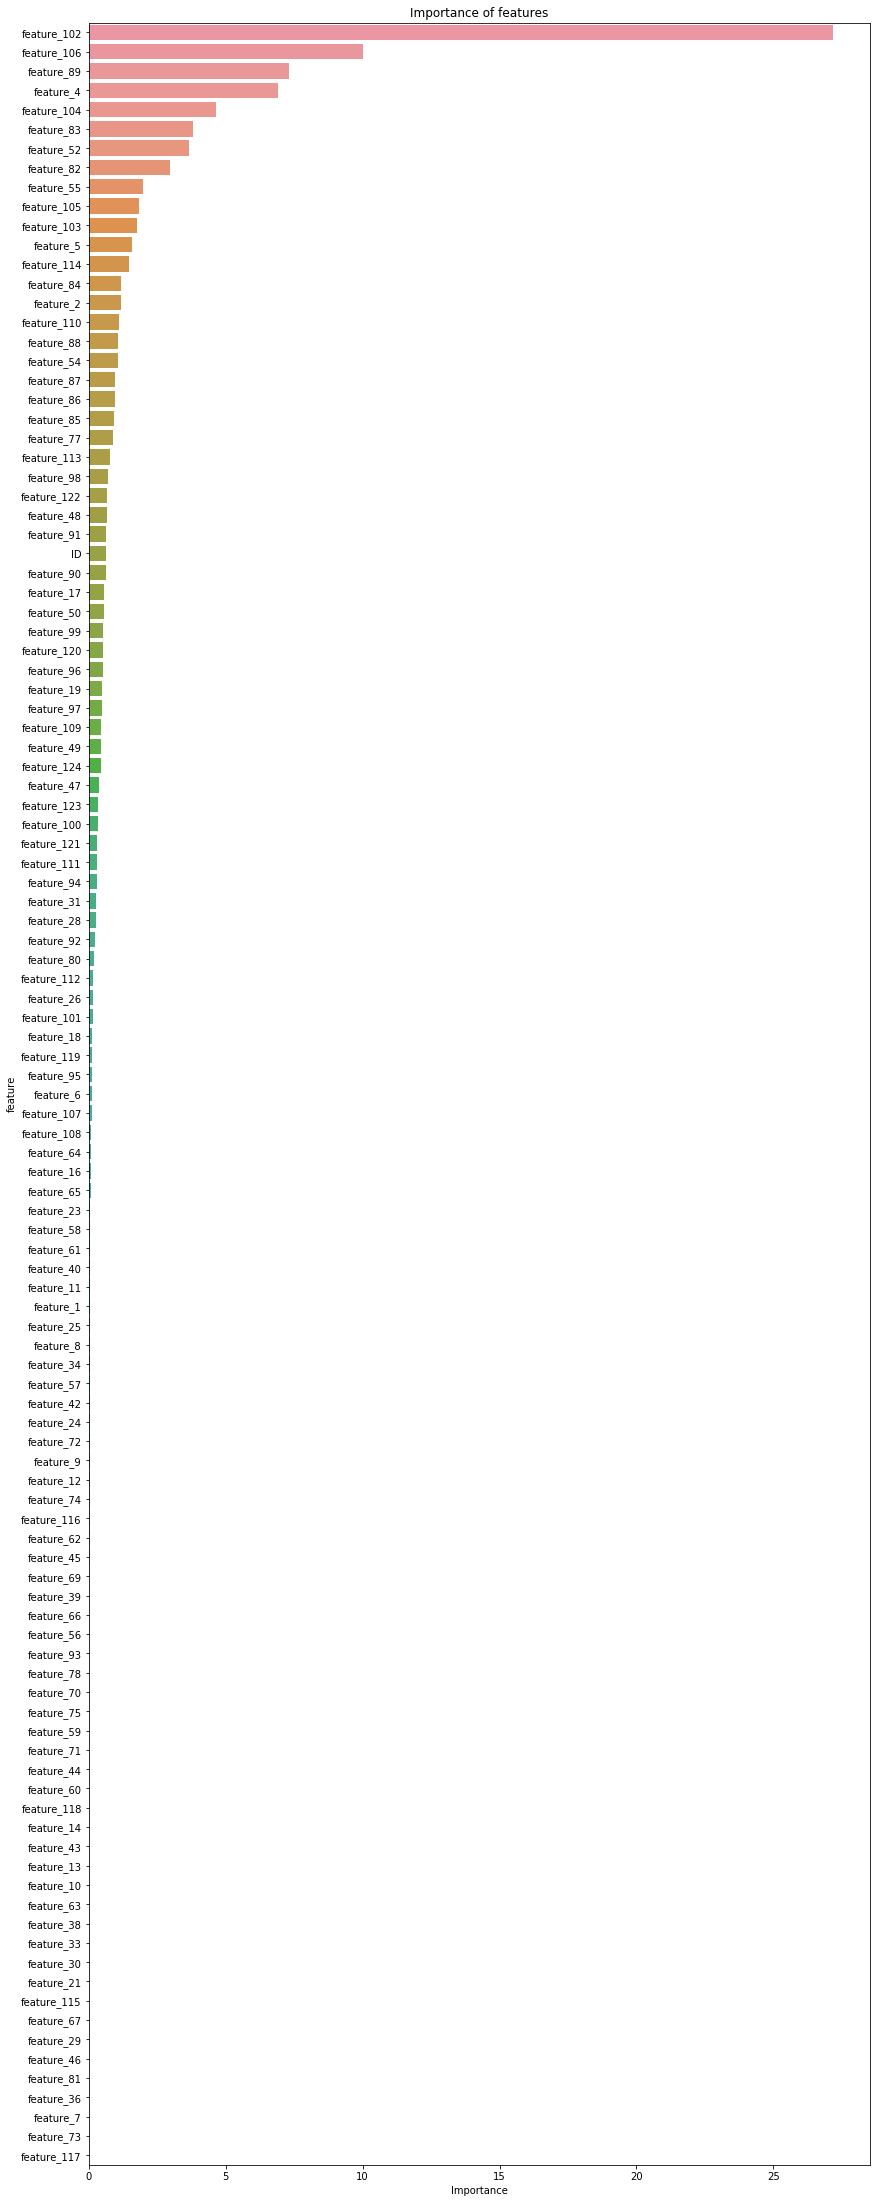

In [34]:
important_features_top = show_feature_importances(X_train.columns, 
                                                  model_catb.feature_importances_, 
                                                  get_top=17)

#### Обучаем модель на всем датасете df_train

In [35]:
%%time

X_train = df_train.drop(['target'], axis = 'columns')
y_train = df_train['target']

final_model = catb.CatBoostClassifier(silent=True, random_state=21)

final_model.fit(X_train, y_train)

y_test_pred_probs = final_model.predict_proba(X_train)[:, 1]

Wall time: 52.8 s


### Выбор порога вероятности для определения класса

По результатам расчетов выбираем порог вероятности = **0,313**

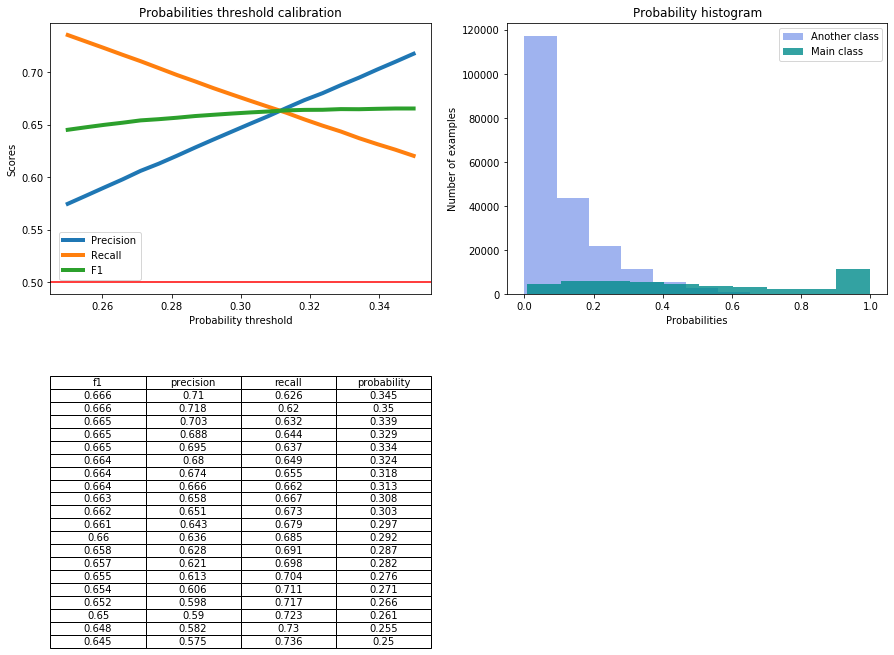

In [36]:
#y_test_pred_probs = final_model.predict_proba(X_test)[:, 1]

show_proba_calibration_plots(y_test_pred_probs, y_train)

**Сгруппируйте выборку по значениям вероятности с шагом 0.1, и в каждой группе посчитайте: сколько объектов в группе, сколько в группе объектов с target = 1.**

In [37]:
df = pd.DataFrame()
df['ID'], df['proba'], df['target'] = df_train['ID'], pd.DataFrame(y_test_pred_probs), df_train['target']

df

,ID,proba,target
0,1,0.203328,0
1,2,0.036711,0
2,3,0.017551,0
3,4,0.017203,0
4,5,0.011858,0
...,...,...,...
255815,255816,0.005124,0
255816,255817,0.036296,0
255817,255818,0.277640,0
255818,255819,0.152108,0


In [38]:
df_group = pd.DataFrame()
bins = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
labels = ['0.0-0.1','0.1-0.2','0.2-0.3', '0.3-0.4','0.4-0.5','0.5-0.6', '0.6-0.7','0.7-0.8','0.8-0.9', '0.9-1.0']

df_group = df.groupby(pd.cut(df['proba'], bins=bins, labels=labels)).size().reset_index(name='count')

df_group_ = df.groupby(pd.cut(df['proba'], bins=bins, labels=labels))['target'].sum().reset_index(name='target=1')

df_group['target=1'] = df_group_['target=1']

df_group

,proba,count,target=1
0,0.0-0.1,126234,4164
1,0.1-0.2,49489,6122
2,0.2-0.3,27317,6067
3,0.3-0.4,16045,5557
4,0.4-0.5,9660,4686
5,0.5-0.6,6166,4009
6,0.6-0.7,3991,3224
7,0.7-0.8,2719,2515
8,0.8-0.9,2552,2520
9,0.9-1.0,11647,11646


**Считаем Джини кэоф. по 'target'**

In [39]:
if __name__ == '__main__':
    salary = df_group['target=1'].to_dict()

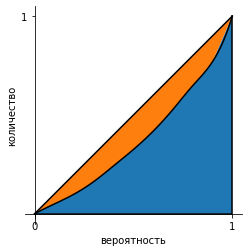

0.25098792318352814


In [45]:
print(GiniIndex(list(salary.values())))

## Прогнозирование на тестовом датасете

**Загрузка тестовых данных**

In [41]:
df_test = pd.read_csv(TEST_DATASET_PATH, delimiter =';')
df_test.head()

,ID,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_115,feature_116,feature_117,feature_118,feature_119,feature_120,feature_121,feature_122,feature_123,feature_124
0,255821,0,0,0,2268,34,0,1,0,0,...,1,0,0,0,0.0,6000,1000,4551.0204,12000,0.500000
1,255822,0,0,0,42,49,0,0,1,0,...,0,0,0,0,0.0,6000,3400,4700.0000,6000,1.000000
2,255823,0,0,0,265,69,0,1,0,0,...,0,0,0,0,0.0,3000,3000,4133.3333,6000,0.500000
3,255824,1,0,0,834,25,1,0,1,0,...,0,0,0,0,0.0,2000,1000,3875.0000,11000,0.181818
4,255825,0,0,0,772,26,1,1,0,0,...,1,0,0,0,0.0,8000,2000,7640.0000,12000,0.666667


### Обработка пропусков<a class="anchor" id="gaps"></a>

In [42]:
df_train.isnull().sum().sort_values(ascending = False).head(10)

target         0
feature_124    0
feature_36     0
feature_38     0
feature_39     0
feature_40     0
feature_42     0
feature_43     0
feature_44     0
feature_45     0
dtype: int64

### Предсказываем целевую переменную, используя модель, построенную на обучающем датасете

#### Делаем предсказание на тестовых данных

In [43]:
y_test_pred_probs = final_model.predict_proba(df_test)[:, 1]

In [46]:
y_test_labels = pd.DataFrame()
y_test_labels['ID'] = df_test['ID']
y_test_labels['score'] = pd.DataFrame(y_test_pred_probs)

y_test_labels.to_csv('Test_score.csv', header=None, index=None, sep = ';')

#### Сдвигаем порог вероятности и сохраняем предсказания 'target'

In [48]:
y_test_labels_ = pd.DataFrame()

y_test_labels_['ID'] = df_test['ID']
y_test_labels_['target'] = pd.DataFrame(np.array(y_test_pred_probs > 0.313, dtype=int))

y_test_labels_.to_csv('Test_target.csv', header=None, index=None, sep = ';')